In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
# Training sample
data = pd.read_csv('data/training.csv')
data = data.drop('timestamp',axis=1)

In [6]:
# Users metadata
usersdb = pd.read_csv('data/users.dat',sep='::',header=None,names=['UserID','Gender','Age','Occupation','Zip-code'])
usersdb = pd.get_dummies(usersdb, columns=['Gender'], drop_first=True)

/Users/agnesubelyte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


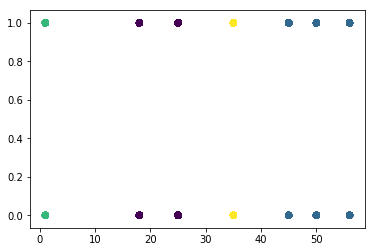

In [7]:
#Kmeans clustering
dataKmeans = usersdb[['Age','Gender_M']]
kmeans_model = KMeans(n_clusters=4, n_init = 10, max_iter =100, random_state=1).fit(dataKmeans)
labels=kmeans_model.labels_
silhouette_score(dataKmeans, labels, metric='euclidean') #0.78
plt.scatter(dataKmeans.iloc[:,0],dataKmeans.iloc[:,1],c=labels)

In [8]:
#Joining kmeans labels and data matrix on user id
data_matrix_pd = pd.pivot_table(data, values='rating', index=['user'], columns=['movie'], aggfunc=np.mean)
data_matrix_pd['index1'] = data_matrix_pd.index

labels=pd.DataFrame(labels)
labels['index1'] = labels.index+1

data_matrix_merged=pd.merge(labels, data_matrix_pd, on='index1',how='outer')
data_matrix_merged=data_matrix_merged.sort_values(by=['index1'])
data_matrix_merged=data_matrix_merged.set_index('index1')
data_matrix_merged.rename(columns ={0: 'label'}, inplace =True)

In [9]:
data_matrix_merged.iloc[0:10,:]

,label,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
index1,,,,,,,,,,,,,,,,,,,,,
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#import math
#for i in range(6039,6040):
#    for j in range(data_matrix_merged.shape[1]):
#        if math.isnan(data_matrix_merged.iloc[i,j]):
#            cluster=data_matrix_merged['label'].iloc[i]
#            data_matrix_merged.iloc[i,j]=np.mean(data_matrix_merged.iloc[:,j].loc[data_matrix_merged['label'] == cluster])

#data_matrix_merged.to_csv('data/data_matrix_merged.csv')

In [10]:
#Filling in missing values with average of ratings given to a movie by users in that cluster
data_matrix_merged1 = pd.read_csv('data/data_matrix_new.csv')
data_matrix_merged1 = data_matrix_merged1.set_index('index1')
cols=data_matrix_merged.columns
data_matrix_merged1.columns = cols
data_matrix_merged = data_matrix_merged1

In [11]:
data_matrix_merged.iloc[0:10,:]

,label,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
index1,,,,,,,,,,,,,,,,,,,,,
1,2,3.860215,3.300000,3.307692,3.333333,3.461538,3.769231,3.461538,2.833333,2.666667,...,2.500000,1.0,2.000000,2.333333,NaN,4.166667,5.000000,3.0,NaN,3.777778
2,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.0,4.000000
3,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.4,3.482353
4,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.0,4.000000
5,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.4,3.482353
6,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.0,4.000000
7,3,4.301939,3.352941,2.969697,2.666667,3.195652,3.770370,3.480519,3.600000,2.800000,...,2.833333,2.0,1.000000,2.100000,2.400000,3.767123,4.400000,4.0,4.2,3.918919
8,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.4,3.482353
9,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.4,3.482353


In [12]:
#There are still some missing values, fill them in with column means (total average rating of a movie)
#data_matrix_pd_fillna = data_matrix_pd.fillna(data['rating'].mean())
for j in range(data_matrix_merged.shape[1]):
    data_matrix_merged.iloc[:,j]=data_matrix_merged.iloc[:,j].fillna(data_matrix_merged.iloc[:,j].mean())

In [13]:
data_matrix_merged.iloc[0:5,:]

,label,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
index1,,,,,,,,,,,,,,,,,,,,,
1,2,3.860215,3.300000,3.307692,3.333333,3.461538,3.769231,3.461538,2.833333,2.666667,...,2.500000,1.0,2.000000,2.333333,3.341516,4.166667,5.000000,3.0,3.711157,3.777778
2,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.000000,4.000000
3,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.400000,3.482353
4,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.000000,4.000000
5,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.400000,3.482353


In [14]:
#Convert the wide matrix into long format for ALS model
data_matrix_merged = data_matrix_merged.drop('label',axis=1)
data_matrix_long=data_matrix_merged.unstack().reset_index()
data_matrix_long.rename(columns ={'level_0': 'movie','index1': 'user',0: 'rating'}, inplace =True)

In [15]:
data_matrix_long.iloc[0:5,:]

,movie,user,rating
0,1,1,3.860215
1,1,2,4.054688
2,1,3,4.138595
3,1,4,4.054688
4,1,5,4.138595


In [16]:
# Convert a Pandas DF to a Spark DF, split into train and test sets
spark_df = spark.createDataFrame(data_matrix_long) 
train, test = spark_df.randomSplit([0.8, 0.2], seed=427471138)

In [23]:
# Create an untrained ALS model.
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    regParam = 0.1,
    rank = 5,
    nonnegative=True) 

In [ ]:
recommender = als_model.fit(train)

##Add predictions
train_tr = recommender.transform(train)
test_tr = recommender.transform(test)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rating",metricName="rmse")

rmse_train=evaluator.evaluate(train_tr)
rmse_test=evaluator.evaluate(test_tr)

# =============================================================================
#Fitting entire dataset
model_final = tvs.fit(spark_df)
best_model_final = model_final.bestModel
 
spark_df_tr = best_model_final.transform(spark_df).toPandas()
spark_df_tr.info()

#Calculating RMSE for train and test sets
rmse_spark_df=evaluator.evaluate(spark_df_tr)
print(best_model_final.rank)
print(best_model_final._java_obj.parent().getMaxIter())
print(best_model_final._java_obj.parent().getRegParam())
 
data_requests_transformed = best_model_final.transform(data_requests_spark).toPandas()
data_requests_transformed = data_requests_transformed.fillna(name_df['rating'].mean())